This notebook analyses the load time of the csv insulin data for the FLAIR study and suggest improvements

In [ ]:
import os, sys
import pandas as pd
import time
from matplotlib import pyplot as plt
%matplotlib inline


In [7]:
#get the file path
current_dir = os.getcwd(); 
original_data_path = os.path.join(current_dir, '..', 'data/raw')
cleaned_data_path = os.path.join(current_dir,  '..', 'data/cleaned')
path = os.path.join(original_data_path, 'FLAIRPublicDataSet', 'Data Tables', 'FLAIRDevicePump.txt')

## Loading the data 
Check the time it takes to load the csv without optimization

In [13]:
t = time.time()
df_insulin = pd.read_csv(path, sep="|", low_memory=False)
elapsed = time.time() - t
print(f"Loading the Flair pump data (no optimizations) takes {elapsed:.2f}s")

Loading the Flair pump data (no optimizations) takes 14.81s


By reducing to relevant columns, loading should improve

In [15]:
t = time.time()
df_insulin = pd.read_csv(path, sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'BasalRt', 'BolusDeliv', 'ExtendBolusDuration'])
elapsed = time.time() - t
print(f"Loading the Flair pump data (with reduced columns) takes {elapsed:.2f}s")

Loading the Flair pump data (with reduced columns) takes 8.24s


**Learning**: Reduce columns!

## Converting Datetime Strings
We know that conversion to datetimes takes a while, how much?

In [17]:
t = time.time()
df_insulin = pd.read_csv(path,sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'BasalRt', 'BolusDeliv', 'ExtendBolusDuration'],
                         parse_dates=[2]) #the third colum (of the used ones) holds the datestrings
elapsed = time.time() - t
print(f"Loading the Flair pump data with reduced columns + parsing the dates takes {elapsed:.2f}s")

Loading the Flair pump data with reduced columns + parsing the dates takes 244.25s


# speed up date parsing
As we can see the almost 250 seconds are spend on parsing the dates. This takes so long because python does not know if the date format is consistent and therefor needs to switch to dynamic date parsing. We can speed this up by providing the right date formatter string. From the data we see that the datestrings look like **"5/15/2019 11:59:59 PM"** which can be parsed using **'%m/%d/%Y %I:%M:%S %p'** formatter. Let's try this.

In [18]:
## using date formatting
df_insulin = pd.read_csv(path, sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'BasalRt', 'BolusDeliv', 'ExtendBolusDuration'])
try:
    datetimes = pd.to_datetime(df_insulin.DataDtTm, format='%m/%d/%Y %I:%M:%S %p')
except Exception as e:
  # Print the error type and message
  print(f"An error occurred: {type(e).__name__} - {e}")

An error occurred: ValueError - time data '5/15/2019' does not match format '%m/%d/%Y %I:%M:%S %p' (match)


### investigating corrupt rows
This approach fails because there are rows which do not follow the '%m/%d/%Y %I:%M:%S %p'format. Let's investigate how often and why this happens.

In [19]:
outliers = df_insulin[df_insulin.DataDtTm.str.len() <= 10]
print(f"We loaded {df_insulin.shape[0]} rows out of which {outliers.shape[0]} datetime strings come without time components");
print(f"That is {100*outliers.shape[0]/df_insulin.shape[0]:.2f}% of the data")
display(outliers.count().sort_values())

We loaded 5100621 rows out of which 35150 datetime strings come without time components
That is 0.69% of the data


ExtendBolusDuration        0
BolusDeliv                78
BasalRt                 8342
RecID                  35150
PtID                   35150
DataDtTm               35150
dtype: int64

Let's investigate when these outliers happen by looking at the neighboring records (using RecID)

In [41]:
print(outliers.iloc[[0,10000,20000]])
display(df_insulin[(df_insulin.RecID >214-3) & (df_insulin.RecID < 214+3)])
display(df_insulin[(df_insulin.RecID >899451-3) & (df_insulin.RecID < 899451+3)])
display(df_insulin[(df_insulin.RecID >2548734-3) & (df_insulin.RecID < 2548734+3)])

           RecID  PtID   DataDtTm  BasalRt  BolusDeliv ExtendBolusDuration
213          214    26  5/15/2019      NaN         NaN                 NaN
899450    899451   125  5/24/2019      NaN         NaN                 NaN
2468164  2548734    14   1/9/2020      NaN         NaN                 NaN


,RecID,PtID,DataDtTm,BasalRt,BolusDeliv,ExtendBolusDuration
211,212,26,5/15/2019 12:05:18 AM,NaN,0.025,NaN
212,213,26,5/15/2019 12:05:02 AM,NaN,0.025,NaN
213,214,26,5/15/2019,NaN,NaN,NaN
214,215,26,5/14/2019 11:59:59 PM,NaN,NaN,NaN
215,216,26,5/14/2019 11:55:26 PM,NaN,0.125,NaN


,RecID,PtID,DataDtTm,BasalRt,BolusDeliv,ExtendBolusDuration
899448,899449,125,5/24/2019 12:46:14 AM,NaN,NaN,NaN
899449,899450,125,5/24/2019,0.65,NaN,NaN
899450,899451,125,5/24/2019,NaN,NaN,NaN
899451,899452,125,5/23/2019 11:59:59 PM,NaN,NaN,NaN
899452,899453,125,5/23/2019 11:56:26 PM,NaN,NaN,NaN


,RecID,PtID,DataDtTm,BasalRt,BolusDeliv,ExtendBolusDuration
2468162,2548732,14,1/9/2020 12:16:41 AM,NaN,0.35,NaN
2468163,2548733,14,1/9/2020 12:11:41 AM,NaN,0.33,NaN
2468164,2548734,14,1/9/2020,NaN,NaN,NaN
2468165,2548735,14,1/8/2020 11:59:59 PM,NaN,NaN,NaN
2468166,2548736,14,1/8/2020 11:56:38 PM,NaN,0.15,NaN


## lets further investigate for patient nr 26

In [47]:
#get all timestamps sort by record id
p26_sane = df_insulin[(df_insulin.PtID == 26) & (df_insulin.DataDtTm.str.len() >= 10)]
p26_corr = df_insulin[(df_insulin.PtID == 26) & ~(df_insulin.DataDtTm.str.len() >= 10)]


Text(0, 0.5, 'DataDtTm')

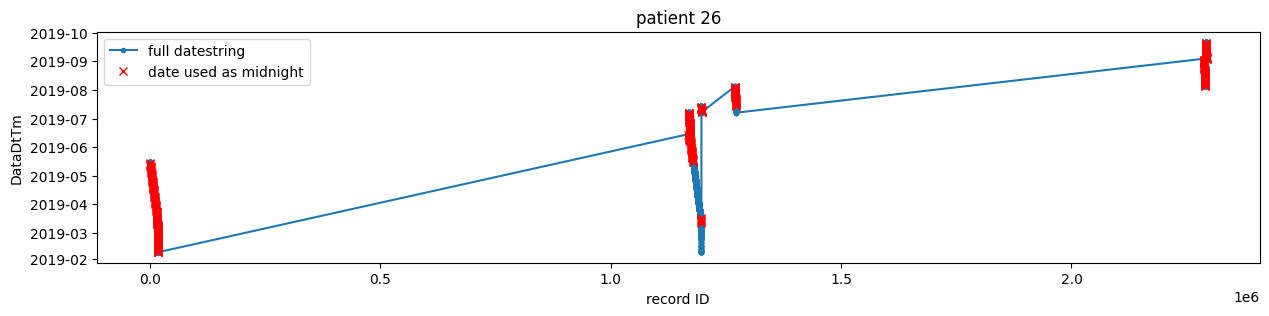

In [142]:
#plot time vs. time (for the correct values)
f=plt.figure(figsize=(15,3))
plt.plot(p26_sane.RecID, pd.to_datetime(p26_sane.DataDtTm),'-',marker='.',label='full datestring')
plt.plot(p26_corr.RecID, pd.to_datetime(p26_corr.DataDtTm),'x',color='red',label='date used as midnight')
plt.title('patient 26'); plt.xlabel('record ID'); plt.ylabel('DataDtTm'); plt.legend(); 

**Observation**: 
1. We see that the record IDs are spread in multiple buckets. This means that the datetimes and record ids globally are not in sequence within a patient. This is likely because they were imported at different times in multiple stages. The glossary does not provide information.
2. Record ids are in reverse to the datetimes: increasing record ids --> decreeasing datetimes

### let's zoom in on the the first bucket of record IDs

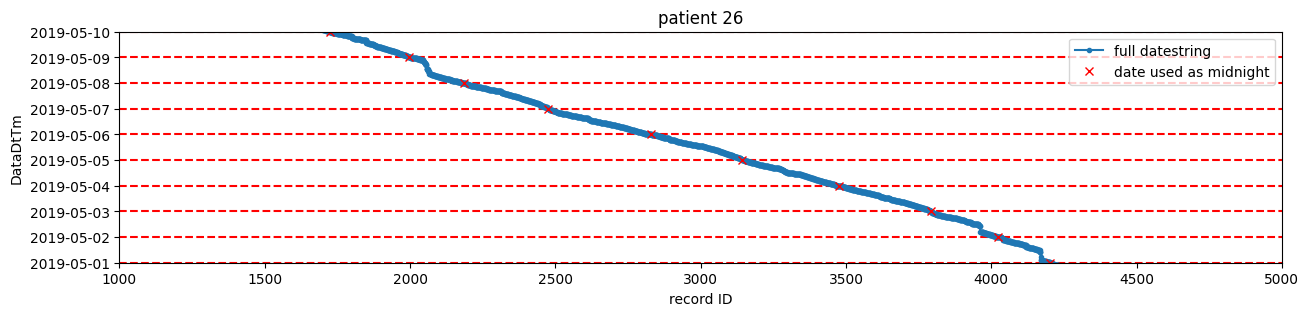

In [143]:
#let's zoom in on the the first bucket of record IDs
ax=f.gca()
#ax.set_xlim([1160000,1185000])
ax.set_xlim([1000,5000])
ax.set_ylim([datetime(2019,5,1),datetime(2019,5,10)])
ax.hlines(pd.to_datetime(p26_corr.DataDtTm),xmin=1000,xmax=5000,color='red',linestyles='--')
f

**Observations**: By looking at this small region, we can see that the corrupted datetimes (interpreted as midnight) are in sequence with other record IDs. If they weren't midnight times (or the record id was wrong), the red markers would be visibly offset from the blue markers. 
- Interpreting the datetsrings as midnight timestamps is *likely* correct.
- Unfortunately the glossary does not provide information on it.

# Speeding up date conversion
We now assume that datestrings without time component represent midnight (start of that specific date at 00:00 AM) times.
1. parse complete datetime strings using format='%m/%d/%Y %I:%M:%S %p'
2. parse incomplete datetime strings using format='%m/%d/%Y'
3. merge both datasets

In [161]:
t = time.time()
t = time.time()
df_insulin = pd.read_csv(path, sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'BasalRt', 'BolusDeliv', 'ExtendBolusDuration'])
b_only_date = (df_insulin.DataDtTm.str.len() <= 10)
df_insulin.loc[b_only_date, 'DataDtTm'] = pd.to_datetime(df_insulin.loc[b_only_date, 'DataDtTm'], format='%m/%d/%Y')
df_insulin.loc[~b_only_date, 'DataDtTm'] = pd.to_datetime(df_insulin.loc[~b_only_date, 'DataDtTm'], format='%m/%d/%Y %I:%M:%S %p')
elapsed = time.time() - t
print(f"Converting datetimes (with optimization) takes {elapsed:.2f}s")

Converting datetimes (with optimization) takes 28.00s


## Conclusion
Loading CSVs is painfully slow due to the need for parsing datetime strings. Python has to rely on dynamially interpreting the format. Passing the format string fails because for some rows, the time component in the datetime string is missing. This is likely happening whenever the timestamp represents midnight. It might even be that for every midnight, data is being reported.
To resolve this we accept the "midnight" assumption. 

By splitting the dataset and parsing dates in two passes, we reduce the load time from ~250s down to 28s.

In [ ]:
## checking if cgm is also affected

In [162]:
#get the file path
path = os.path.join(original_data_path, 'FLAIRPublicDataSet', 'Data Tables', 'FLAIRDeviceCGM.txt')
t=time.time()
df_cgm = pd.read_csv(path, sep="|", low_memory=False)
print(f"Loading the Flair pump data (no optimizations) takes {time.time() - t:.2f}s")

Loading the Flair pump data (no optimizations) takes 4.57s


In [171]:
df_cgm.DataDtTm.str.len().value_counts()

20    2758810
21    1594549
19     897440
22     258126
9          33
8          17
10         10
Name: DataDtTm, dtype: int64

Yes, we have have roughly 60 cases

In [177]:
temp = df_cgm.loc[df_cgm.PtID== 28]
b_no_time = temp.DataDtTm.str.len()<=10
temp['DateTime']=pd.to_datetime(temp.DataDtTm)


/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_48733/3733113694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['DateTime']=pd.to_datetime(temp.DataDtTm)


(17944.0, 17948.0)

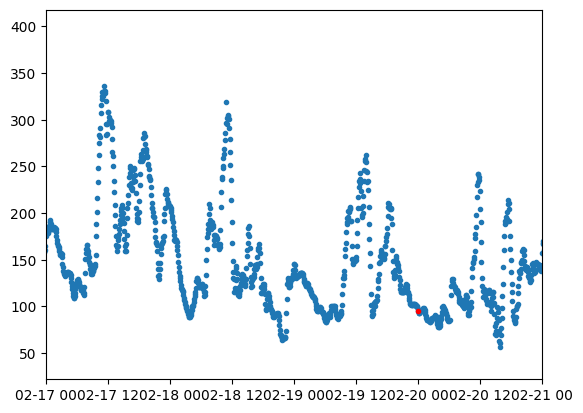

In [185]:
plt.scatter(temp.DateTime,temp.CGM,marker='.')
plt.scatter(temp.loc[b_no_time,'DateTime'],temp.loc[b_no_time,'CGM'],color='red',marker='.')
plt.xlim([datetime(2019,2,17),datetime(2019,2,21)])

In [ ]:
The value fits into the cgm trace when interpreted as midnight